# 1. Data wrangling

The present notebook contains the data wrangling process, including collecting, inspecting and cleaning the data for further exploration and modelling. It entails the following steps: 

1. Data collection 
2. Feature extraction
3. Feature analysis and profiling
4. Quality assessment and data cleaning

The first step is to import the necessary packages

In [1]:
# Import the required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
# Set visual style for graphs

plt.style.use('seaborn')

---
## 1.1. Data collection

This step involves gathering data from different sources and put together a single structure, usually a dataframe. In this case, the dataset has been already provided from a urban hotel customer database query, so it is expected to have little missing or inconsitent values. 

The dataset metadata already indicated the content of 79,330 observations and 31 variables in the dataset, corresponding to hotel bookings from 1st of July 2015 to 31st of August 2017.

We will explore features, data types and potential missing values.

In [3]:
# Import original dataset and load it into a dataframe

file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/raw/H2.csv'

df = pd.read_csv(file, index_col=None)

In [4]:
# Checks number of rows and columsn

df.shape

(79330, 31)

In [5]:
# First visual inspection of the content

df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [6]:
# Checks columns NaN values and data types 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

We can see that the dataset contains a combination of discrete and continuous numerical, and categorical variables, with the exception of four of them which contains datetime information.

---
## 1.2. Feature extraction

In this section, we will create new columns (features) from the existing in the dataset. The objective of this step is to create meaningful attributes that could be better interpreted by the clustering algorithm and by ourselves.

- "ArrivalDate" variables can be merged into a single one to facilitate its inspection and handling.

In [7]:
# Combine "ArrivalDate"columns into a single datetime variable
df['ArrivalDate'] = pd.to_datetime(df[['ArrivalDateYear','ArrivalDateMonth','ArrivalDateDayOfMonth']]
                                   .astype(str).apply(' '.join, 1), format='%Y %B %d')

# Update "ReservationStatusDate" data type
df['ReservationStatusDate'] = df['ReservationStatusDate'].astype('datetime64[ns]')

- We will create 'ReservationDate' indicating the date when the reservation was made by substracting the LeadTime to the ArrivalDate

In [8]:
# Changes data type to float
df['LeadTime'] = df['LeadTime'].astype('float')

# Creates new variable containing reservation dates by substracting LeadTime from ArrivalDate
df['ReservationDate'] = [df.loc[i,'ArrivalDate'] - timedelta(days=df.loc[i,'LeadTime']) for i in df.index]

In [9]:
# Print sample of these two variables

df[['ArrivalDate', 'ReservationDate']].head()

,ArrivalDate,ReservationDate
0,2015-07-01,2015-06-25
1,2015-07-01,2015-04-04
2,2015-07-01,2015-04-27
3,2015-07-01,2015-03-31
4,2015-07-02,2015-03-24


- An additional feature 'ChangedRoom' is created to indicate if the guest changed rooms upon arrival.

In [10]:
# Creates nwe variable and assing all values to 0
df['ChangedRoom'] = 0

# Assigns 1 to all values where Reserved Room Type is not the same as Assigned Room Type
df['ChangedRoom'].where(df.ReservedRoomType == df.AssignedRoomType, 1, inplace=True)

In [11]:
# Checks result
df['ChangedRoom'].value_counts()

0    72138
1     7192
Name: ChangedRoom, dtype: int64

- 'TotalStay' will reflect the overall number of nights reserved.

In [12]:
# Creates 'TotalStay'
df['TotalStay'] = (df['StaysInWeekendNights'] + df['StaysInWeekNights']).astype('float')

- 'StayChanges' is created to reflect if the guest extended his stay, left early or stayed the original reserved days.

In [13]:
# Calculates check out date
df['CheckOutDate'] = [df.loc[i, 'ArrivalDate'] + timedelta(days=df.loc[i,'TotalStay']) for i in df.index]

In [14]:
# Calculates if guest extended or shorten his/her stay from original booking
for i in df.index:
    if (df.loc[i,'CheckOutDate'] < df.loc[i,'ReservationStatusDate']) & (df.loc[i,'ReservationStatus'] == 'Check-Out'):
        df.loc[i, 'StayChanges'] = 'Extended'
    elif (df.loc[i,'CheckOutDate'] > df.loc[i,'ReservationStatusDate']) & (df.loc[i,'ReservationStatus'] == 'Check-Out'):
        df.loc[i, 'StayChanges'] = 'Early Check-Out'
    else:
        df.loc[i, 'StayChanges'] = 'No Changes'

In [15]:
# Checks result
df['StayChanges'].value_counts()

No Changes         79324
Early Check-Out        6
Name: StayChanges, dtype: int64

---
## 1.3. Feature analysis and profiling

In this section, we will inspect the values, distribution and descriptive statistics of the variables individually.

Firstly, the summary statistics of numerical variables are presented below to check for inconsistencies

In [16]:
# Check summary statistics for numeric variables

df.describe().T

,count,mean,std,min,25%,50%,75%,max
IsCanceled,79330.0,0.417270,0.493111,0.0,0.0,0.0,1.0,1.0
LeadTime,79330.0,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,79330.0,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateWeekNumber,79330.0,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,79330.0,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,79330.0,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,0.091370,0.372177,0.0,0.0,0.0,0.0,3.0
Babies,79330.0,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0


We can observe that values seem to be within normal ranges, except for some outliers in the reservation lead time (LeadTime), Average Daily Rate (ADR), Number of days in waiting lists (DaysInWaitingList) and stays in week nights (StaysInWeekNights). 

Previous Cancellations, Previous Bookings Not Canceled, Booking Changes seem highly unbalanced, most of the observations have value 0.

Let's inspect these variables further with a boxplot:

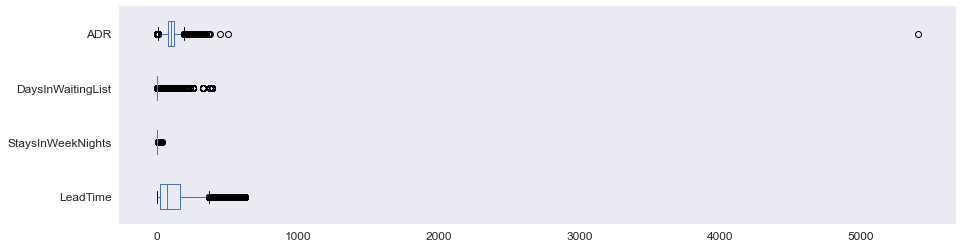

In [17]:
# Plot boxplot for selected numerical variables

df[['LeadTime', 'StaysInWeekNights', 'DaysInWaitingList', 'ADR']].boxplot(grid=False, vert=False, fontsize=12, figsize=(15,4))
plt.show()

It is possible that these are not input errors. Maybe a certain guests made very special requests and was charged EUR 5,400 per night, in any case this is clearly an exception and represents a single value of +70,000 so we can safely remove it.

In [18]:
# Eliminates values in ADR higher than EUR 1,000

df = df[df['ADR'] < 1000]

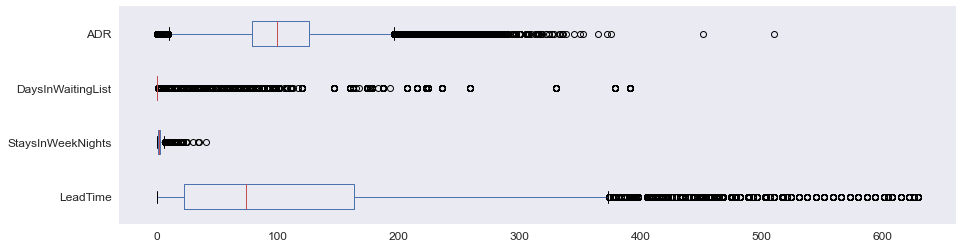

In [19]:
# Plot boxplot for selected numerical variables

df[['LeadTime', 'StaysInWeekNights', 'DaysInWaitingList', 'ADR']].boxplot(grid=False, vert=False, fontsize=12, figsize=(15,4))
plt.show()

We can clearly see that there are many outliers in the distribution. We will plot the histogram below to understand better the dirtibution shape.

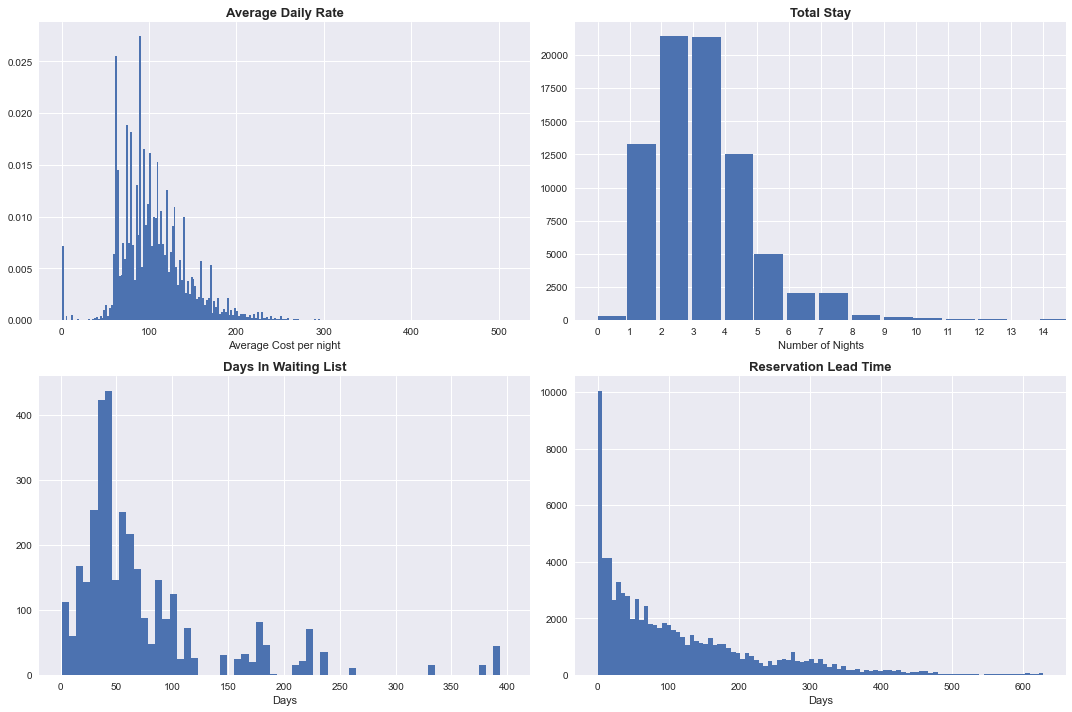

In [20]:
# Plot histograms for selected variables. We have adjusted the ranges and bin number for visualization purposes

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10), dpi=72)

ax0.hist(df['ADR'], bins='auto', density=True)
ax0.set_title('Average Daily Rate', fontsize=13, fontweight='bold')
ax0.set_xlabel('Average Cost per night')

ax1.hist(df['TotalStay'], bins='auto', range=(0,14), width=0.9)
ax1.set_xticks(range(0,15))
ax1.set_title('Total Stay', fontsize=13, fontweight='bold')
ax1.set_xlabel('Number of Nights')

ax2.hist(df['DaysInWaitingList'], bins='auto', range=(1,400))
ax2.set_title('Days In Waiting List', fontsize=13, fontweight='bold')
ax2.set_xlabel('Days')

ax3.hist(df['LeadTime'], bins='auto')
ax3.set_title('Reservation Lead Time', fontsize=13, fontweight='bold')
ax3.set_xlabel('Days')

plt.tight_layout()
plt.show()

It can be seen that:
- Average Daily Rates has bell-shape distribution with long right tail. Values are distributed arround EUR 100 and median and mean are similar. It is worth noting that there are many observations with value 0, probably due to cancellations. Another striking feature is that there are reservations with rates lower than EUR 30 potentially indicating changes in current reservations but that have been recorded as new ones.

- Number of Nights per Stay also has a distribution with long right tail. It peaks at value 2.

- Similarly, distribution for Days in Waiting List peaks arround 40 and has a long right tail. The histogram shows some waiting times of more than a year.

- The distribution for Reservation Lead Time seems to be exponential, with a peak in 0 and decaying rapidly as number of days increase.

Secondly, we will check the distribution of __categorial and discrete__ variables

In [21]:
# Create a function to generate a PMF plot for categorical and discrete variables

def Pmf(series, Title):
    '''Generates a probability mass function (PMF) of a pandas series'''
    value = series.value_counts().sort_index()
    pmf = value*100 / len(series)
    plt.bar(value.index, pmf)
    plt.xticks(value.index, fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Frequency', fontsize=13)
    plt.title(Title, fontsize=15, fontweight='bold')

Let's explore first the __number of guests per reservation__

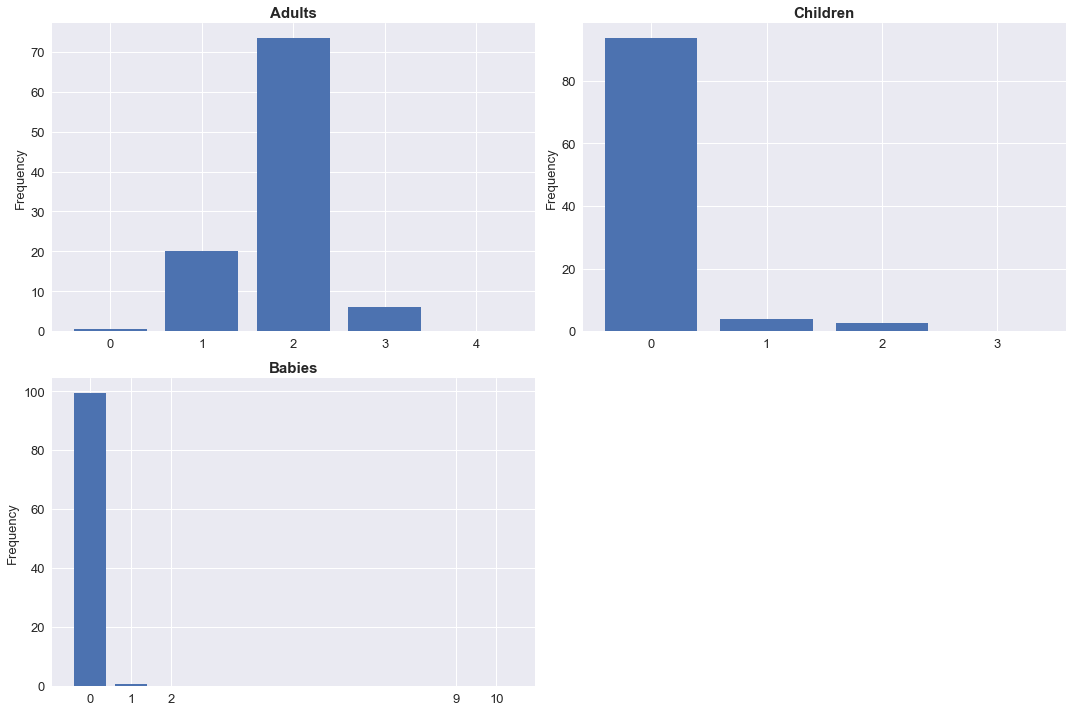

In [22]:
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot number of adults per booking
plt.subplot(2,2,1)
Pmf(df['Adults'], 'Adults')

# Plot number of children per booking
plt.subplot(2,2,2)
Pmf(df['Children'], 'Children')

# Plot number of babies per booking
plt.subplot(2,2,3)
Pmf(df['Babies'], 'Babies')

plt.tight_layout()
plt.show()

We can observe that over 70% of bookings are for two adults, with no children. Reservations including babies are very rare. 
Interestingly, there are a few bookings for 9 or 10 babies. This could be either a reservarion mistake or a very special group reservation. In any case we believe it is better to remove those outliers considering they are only two observations with these values.

It is also worth noting that there are some reservation with 0 adults; let's explore this further

In [23]:
# Print reservations with 0 'adults' 

df[df['Adults'] == 0].head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDate,ReservationDate,ChangedRoom,TotalStay,CheckOutDate,StayChanges
332,0,132.0,2015,July,30,23,2,5,0,0.0,...,0,0,Check-Out,2015-07-30,2015-07-23,2015-03-13,0,7.0,2015-07-30,No Changes
862,0,0.0,2015,August,33,9,2,0,0,0.0,...,0,0,Check-Out,2015-08-11,2015-08-09,2015-08-09,1,2.0,2015-08-11,No Changes
924,0,1.0,2015,August,33,10,1,1,0,3.0,...,0,0,Check-Out,2015-08-12,2015-08-10,2015-08-09,0,2.0,2015-08-12,No Changes
960,0,0.0,2015,August,33,10,9,20,0,0.0,...,0,0,Check-Out,2015-09-08,2015-08-10,2015-08-10,1,29.0,2015-09-08,No Changes
988,0,104.0,2015,August,33,11,0,3,0,2.0,...,0,2,Check-Out,2015-08-14,2015-08-11,2015-04-29,0,3.0,2015-08-14,No Changes


It seems that 'Adults' with value 0 could be a booking change such as adding childrens to the reservation or input errors, which should be removed to avoid biased results in our analysis and segmentation exercise.  

In the cell below we will explore attributes related to __reservations options__:

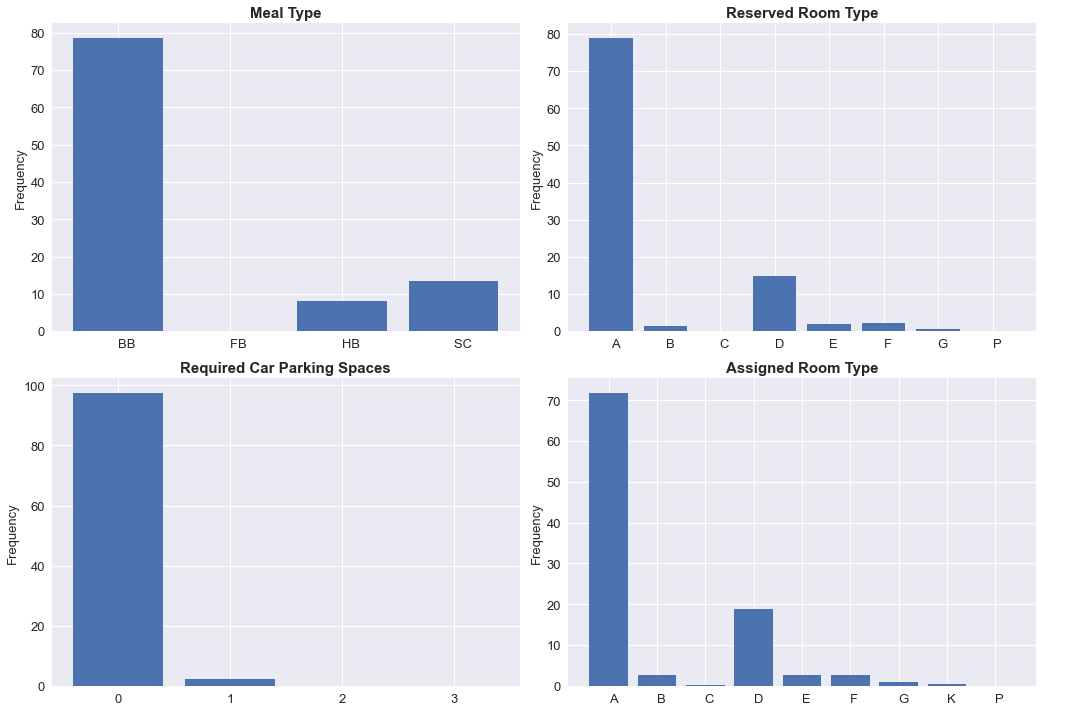

In [24]:
# Creates figure for plots
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot type of meal per booking
plt.subplot(2,2,1)
Pmf(df['Meal'], 'Meal Type')
plt.xticks(horizontalalignment='left')

# Plot Reserved Room Type per booking
plt.subplot(2,2,2)
Pmf(df['ReservedRoomType'], 'Reserved Room Type')
plt.xticks(horizontalalignment='left')

# Plot Required Car Parking Spaces per booking
plt.subplot(2,2,3)
Pmf(df['RequiredCarParkingSpaces'], 'Required Car Parking Spaces')

# Plot Assigned Room Type per booking
plt.subplot(2,2,4)
Pmf(df['AssignedRoomType'], 'Assigned Room Type')
plt.xticks(horizontalalignment='left')

plt.tight_layout()
plt.show()

- Around 15% of bookings did not include meal package (SC) and almost 80% chose Bed&Breakfast option (BB)

- In the case of Reserved Room Type, a code is presented instead of designation for anonymity reasons. It can be seen that only two room types accounts for the majority of reservations (~95%). In general, guests stay in same rooms types they reserved, although sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request.

- The overwhelming majority of reservations did not request parking space.

Now, we will explore __client-related features__, such as customer type, the distribution channel, or if the customer is regular or new. 

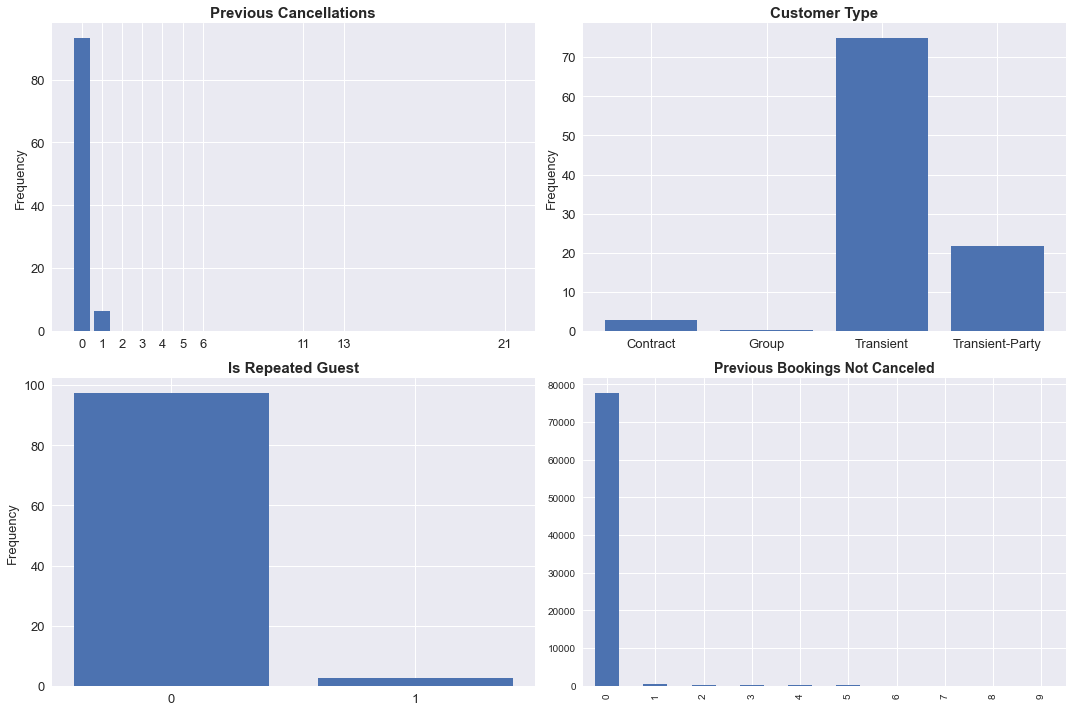

In [25]:
# Creates figure for plots
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot customer previous cancellations
plt.subplot(2,2,1)
Pmf(df['PreviousCancellations'], 'Previous Cancellations')

# Plot Customer Type
plt.subplot(2,2,2)
Pmf(df['CustomerType'], 'Customer Type')

# Plot Is Repeated Guest
plt.subplot(2,2,3) 
Pmf(df['IsRepeatedGuest'], 'Is Repeated Guest')

# Plot Previous Bookings Not Canceled
plt.subplot(2,2,4)
df['PreviousBookingsNotCanceled'].value_counts()[:10].plot(kind='bar')
plt.title('Previous Bookings Not Canceled', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

It can be seen that:
- ~5% of guests cancelled previous reservations.
- Only 5% of reservations are under general corporate contracts or group reservations.
- Less that 5% are recurring customers.
- Less that 5% made reservations and did not cancel.

Attributes about __reservation details__ are inspected below:

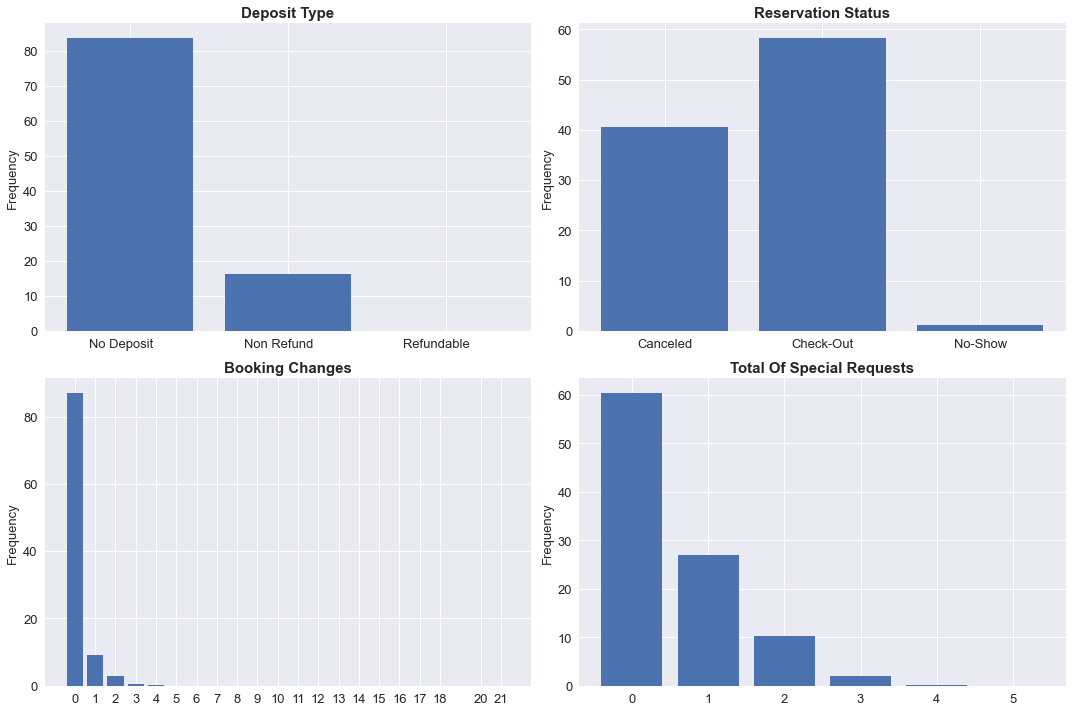

In [26]:
# Creates figure for plots
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot Deposit Type per booking
plt.subplot(2,2,1)
Pmf(df['DepositType'], 'Deposit Type')

# Plot Canceled bookings
plt.subplot(2,2,2)
Pmf(df['ReservationStatus'], 'Reservation Status')

# Plot Booking Changes
plt.subplot(2,2,3) 
Pmf(df['BookingChanges'], 'Booking Changes')

# Plot Total Of Special Requests per booking
plt.subplot(2,2,4)
Pmf(df['TotalOfSpecialRequests'], 'Total Of Special Requests')

plt.tight_layout()
plt.show()

- Only ~15% of guests do make deposit in advance to secure the reservation.
- Over 40% of bookings are canceled before check-in.
- About 15% of guests make at least 1 change in the reservation before check-in or cancellation.
- About 1/3 of reservations made one or two special request in the reservations, including additional bed, late check-in, meal restrictions, etc.

__Marketing__ realated attributes are inspected in following cells:

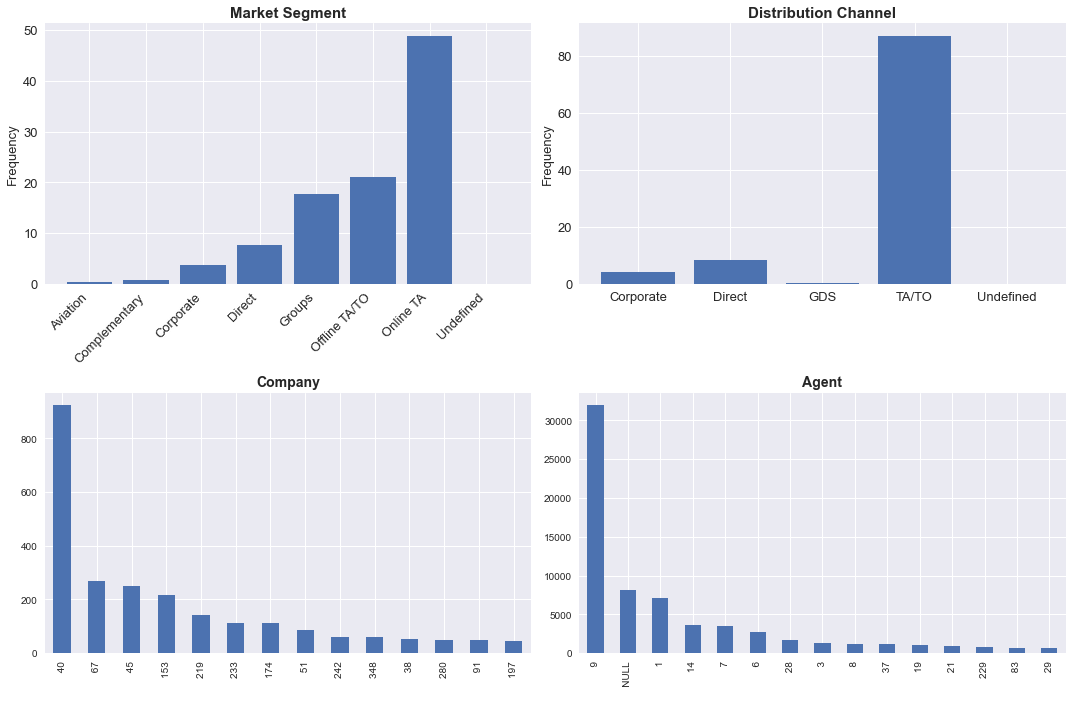

In [27]:
# Creates figure for plots
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot Market Segment per booking
plt.subplot(2,2,1)
Pmf(df['MarketSegment'], 'Market Segment')
plt.xticks(rotation=45, horizontalalignment='right')

# Plot Distribution Channel per booking
plt.subplot(2,2,2)
Pmf(df['DistributionChannel'], 'Distribution Channel')

# Plot Company making the reservation
plt.subplot(2,2,3) 
df['Company'].value_counts()[1:15].plot(kind='bar')
plt.title('Company', fontsize=14, fontweight='bold')

# Plot Agent related with the reservation
plt.subplot(2,2,4)
df['Agent'].value_counts()[:15].plot(kind='bar')
plt.title('Agent', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

We can see that:
- Roughly 50% of reservations are booked through online travel agencies.
- Travel operators and agencies account for 85% of bookings.
- There are mainly four companies which account for the majority of corporate reservations.
- A single agent accounts for roughly half of reservations, it is most likely an online travel agency.

The __customer's country of origin__ is inspected in the cells below: 

In [28]:
# Shows the number of countries origin of guests

print('There are '+str(df['Country'].nunique())+' different countries of origin in the dataset')

There are 166 different countries of origin in the dataset


_Country_ has a high cardinality and this could lead to very sparse matrix when we transform the categories into dummy variables. The best option will be regrouping categories even though we lose some information.   

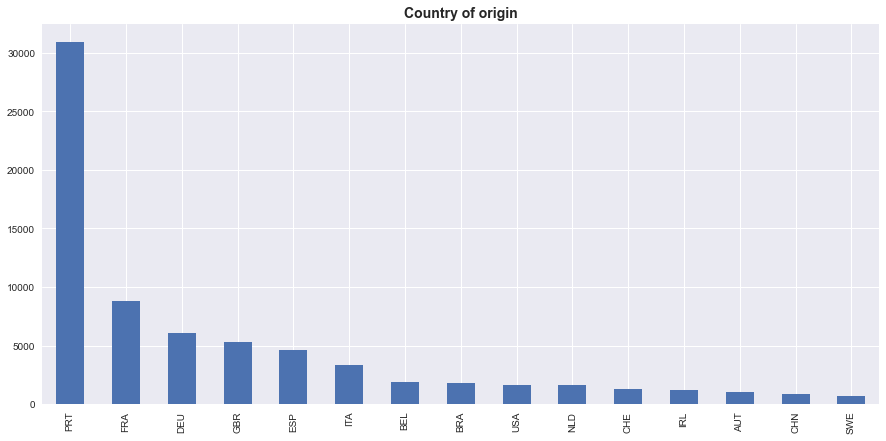

In [29]:
# Creates figure for plots
fig = plt.figure(figsize=(15,7), dpi=72)

# Plots the first more common country of origin of customers
df['Country'].value_counts()[:15].plot(kind='bar')
plt.title('Country of origin', fontsize=14, fontweight='bold')
plt.show()

We can see that almost half of reservations were for a national (Portuguese) guests. The next six most common guest's origins were all European countries.

Finally, we will inspect the accumulated __reservation and arrivals per month__ during the period. We will try to understand if there is any pattern in bookings and arrival dates throughout the year.

In [30]:
# Creates a Series containing total number of arrivals per month of the year

df_arrivals = df['ArrivalDateMonth'].groupby(df['ArrivalDateMonth']).count()
df_arrivals.index = pd.to_datetime(df_arrivals.index, format='%B')
df_arrivals.sort_index(inplace=True)
df_arrivals.index = df_arrivals.index.strftime('%b')

In [31]:
# Creates a Series containing total number of bookings per month of the year

df['ReservationMonth'] = [i.month for i in df['ReservationDate']]

df_bookings = df['ReservationMonth'].groupby(df['ReservationMonth']).count()
df_bookings.index = pd.to_datetime(df_bookings.index, format='%m')
df_bookings.sort_index(inplace=True)
df_bookings.index = df_bookings.index.strftime('%b')

In [32]:
# Converts month number to string
to_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 
           7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
df['ReservationMonth'] = df['ReservationMonth'].map(to_name)

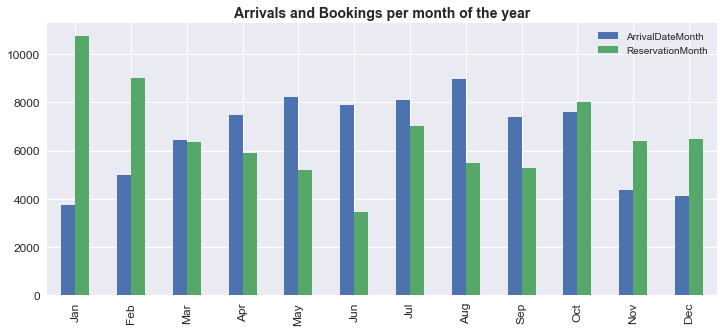

In [33]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12,5), dpi=72)

# Creates plot showing reservations and arrivals per month of year
pd.concat([df_arrivals, df_bookings], axis=1).plot(kind='bar', ax=ax)
ax.set_title('Arrivals and Bookings per month of the year', fontsize=14, fontweight='bold')
ax.tick_params(labelsize=12)

plt.show()

We can clearly see that occupancy in summer months is twice as much than in winter months. Spring occupation increases steadily as it approaches summer and fall occupation decrases toward winter. It seems that there is a clear seasonality in occupancy data.

Reservations peak in January with over 10,000 total bookings and steadly decrease until June, then they raise again until December with 6,000 average total bookings per month.

---
## 1.4. Quality assessment and data cleaning.

In this section, we will check for data intergrity and deal with any potential missing values. Also, we will deal with outliers in the feature's distributions and perform any necessary transformation. 

We have already seen in the previous section a few inconsistent or missing data points in some variables. Since they representa a limited amount of entries, we will replace them with NULL values:

In [34]:
# Replace Undefined data points in MarketSegment
df['MarketSegment'].replace('Undefined', np.NaN, inplace=True)

# Replace Undefined data points in DistributionChannel
df['DistributionChannel'].replace('Undefined', np.NaN, inplace=True)

# Remove trailing spaces from values in DepositType
df['DepositType'] = df['DepositType'].map(lambda x: x.strip())
# Replace Undefined data points in DistributionChannel
df['DepositType'].replace('Refundable', np.NaN, inplace=True)

In [35]:
# Select reservations with values of Adults, Children and Babies equal to 0.
cond = (df.Adults == 0) & (df.Children == 0) & (df.Babies == 0)

# Replace those values for NaN
df['Adults'].mask(cond, inplace=True)

Now, we will deal with outliers in:
- 'DaysInWaitingList': It does not make sense reservations with more than three months in the waiting list, we will assume that those are input errors.
- 'ADR': It does not make sense Average Daily Rates below EUR 40 (except 0) and over EUR 300, so we will treat them as input errors.
- 'Babies': we will assume that reservations with 9 and 10 babies are input errors as well.

In [36]:
# Replace 9 and 10 values in Babies
df['Babies'].replace([9,10], np.NaN, inplace=True)

# Replace reservations with more than 100 days in waiting lists for NaN
# df['DaysInWaitingList'].mask(df.DaysInWaitingList > 100, inplace=True)

# Replace reservations with rates less than EUR 40 and more than EUR 300 for NaN
# df['ADR'].mask(((df.ADR < 40) & (df.ADR > 0)) | (df.ADR > 300), inplace=True)

We will check for missing values in the whole df

In [37]:
# Checks for NaN values in df

df.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                         167
Children                         4
Babies                           2
Meal                             0
Country                         24
MarketSegment                    2
DistributionChannel              4
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                     20
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

In [38]:
# Calculates percentage of NaN values in ADR
per = df.Adults.isna().sum()*100 / df.Adults.shape[0]
print('The propostion of NaN values in ADR feature is '+str(round(per, 3))+'%')

The propostion of NaN values in ADR feature is 0.211%


Rows with NaN values represent less than 0.5% in the worst case scenario, so we can safely remove them because we will not be compromising much information.

In [39]:
# Removes rows with NaN values

df.dropna(axis=0, inplace=True)

---
The resulting dataframe is loaded in a csv file for further steps in a different notebook. 

In [40]:
# Writing df dataframe to csv

path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/interim/clean.csv'

df.to_csv(path)